In [1]:
from utils.geometry import CircularMesh2d, Geometry
from utils import initial_conditions
import fipy as fp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from utils import plot

In [13]:
mesh = CircularMesh2d(15,0.1).mesh
geometry = Geometry(mesh)


In [106]:
radius = 2.5
condensate_com = np.array((5,0))
r_e = np.array((7,0))



c_light = 3.52
c_dense = 4.5
r_e_0 = np.array((10,0))
r_p = np.array((0,0))
sigma = 5

c_vector = fp.CellVariable(mesh=mesh, name='c_1', hasOld=True, value=c_light)
initial_conditions.nucleate_spherical_seed(concentration=c_vector,
                                           value=c_dense,
                                           dimension=2,
                                           geometry=geometry,
                                           nucleus_size=radius,
                                           location=condensate_com)

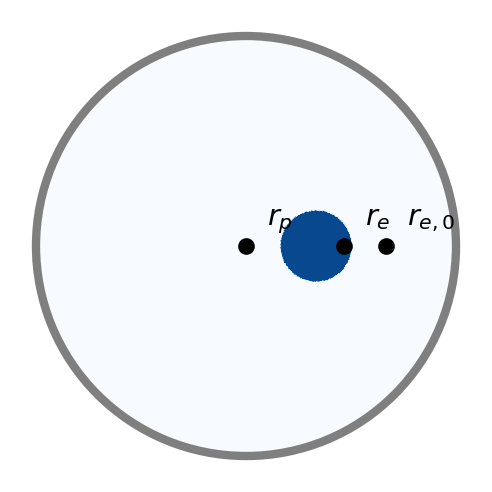

In [108]:
fig, ax = plt.subplots()
fig.set_size_inches((2,2))
cs = ax.tricontourf(mesh.x,
                    mesh.y,
                    c_vector,
                    levels=np.linspace(c_light,
                                       c_dense+0.1,
                                       256),
                    cmap="Blues")
border = plt.Circle((0,0), 15, color='tab:gray', fill=False, linewidth=2)
ax.add_patch(border)
ax.autoscale_view()
ax.xaxis.set_tick_params(labelbottom=False, bottom=False)
ax.yaxis.set_tick_params(labelleft=False, left=False)
ax.set_aspect('equal', 'box')
ax.plot(r_e_0[0],r_e_0[1],marker=".",markersize=6,color="k")
ax.annotate('$r_{e,0}$',xy=r_e_0,fontsize=7,textcoords="offset points",xytext=(5,5))
ax.plot(r_p[0],r_p[1],marker=".",markersize=6,color="k")
ax.annotate('$r_{p}$',xy=r_p,fontsize=7,textcoords="offset points",xytext=(5,5))
ax.plot(r_e[0],r_e[1],marker=".",markersize=6,color="k")
ax.annotate('$r_{e}$',xy=r_e,fontsize=7,textcoords="offset points",xytext=(5,5))
plt.setp(ax.spines.values(), visible=False)
plt.savefig("set.png",dpi=600)

In [84]:
radius = 3
condensate_com = np.array((0,0))
r_e = np.array((0,0))


def init(mesh, radius, condensate_com, arr_r_e, sigma):
    c_light = 3.52
    c_dense = 4.5
    r_e_0 = np.array((10,0))
    # r_p = np.array((-10,0))

    c_vector = fp.CellVariable(mesh=mesh, name='c_1', hasOld=True, value=c_light)
    initial_conditions.nucleate_spherical_seed(concentration=c_vector,
                                            value=c_dense,
                                            dimension=2,
                                            geometry=geometry,
                                            nucleus_size=radius,
                                            location=condensate_com)
    ratio_lst = []
    for r_e in arr_r_e:
        couple_integral = np.array((c_vector * (mesh.cellCenters-r_e) / (sigma**2) * np.exp(-((mesh.x-r_e[0])**2 + (mesh.y-r_e[1])**2)) / (2*sigma**2) * c_vector.mesh.cellVolumes).sum(axis=1))
        enhancer_displacement = r_e-r_e_0
        ratio_lst.append([r_e[0],couple_integral[0],enhancer_displacement[0]])
    return np.array(ratio_lst)

100%|██████████| 11/11 [01:12<00:00,  6.57s/it]


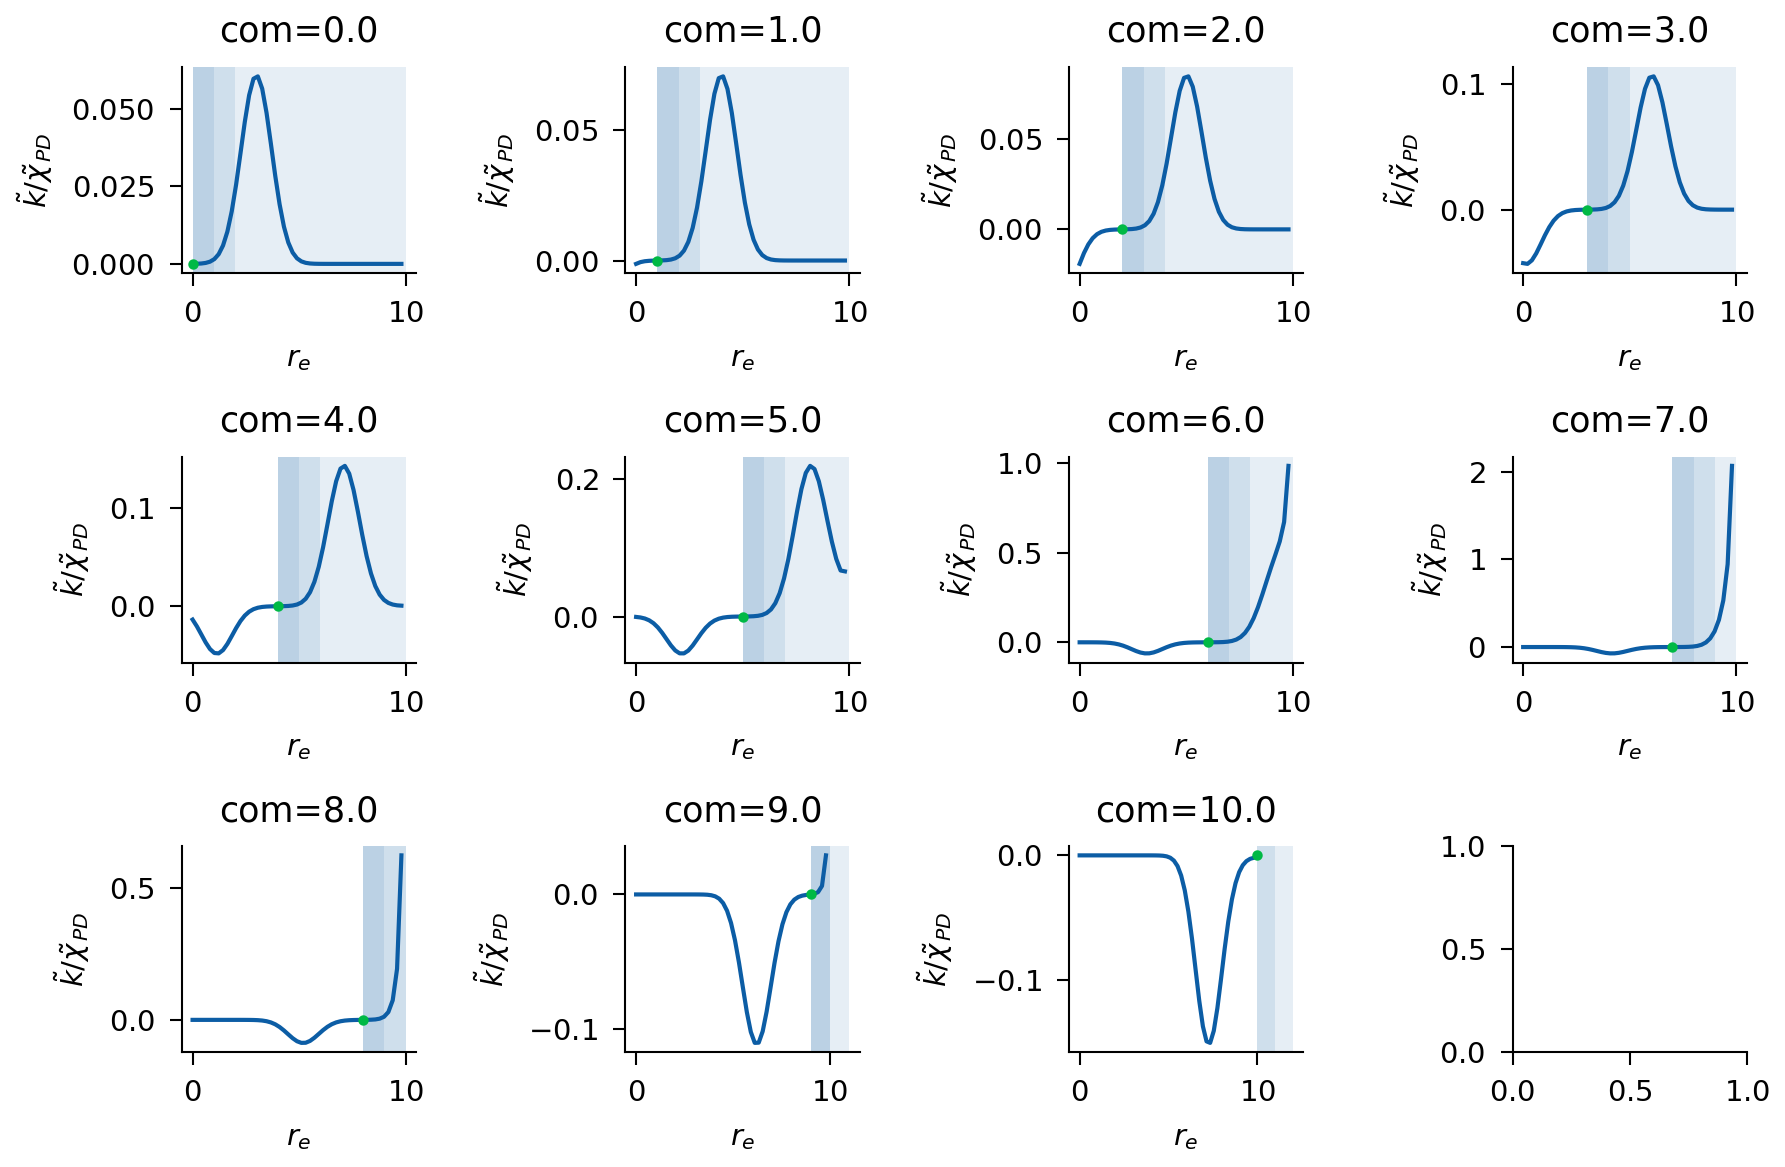

In [156]:
sigma = 1
radius = 2
r_e = np.linspace(0,10,50)
arr_r_e = np.vstack([r_e,np.zeros(len(r_e))]).T
com = np.arange(0,10+1,1)
arr_com = np.vstack([com,np.zeros(len(com))]).T
arr_lst = []
for com in tqdm(arr_com):
    arr = init(mesh,3,com,arr_r_e,sigma)
    arr_lst.append(np.hstack([com[0]*np.ones(len(arr))[:,np.newaxis],arr]))
arr = init(mesh,3,np.array([0,0]),arr_r_e,sigma)
df = pd.DataFrame(np.vstack(arr_lst),columns=["com","r_e","integral","displacement"])
df["ratio"] = df["integral"]/df["displacement"]
pivot = df.pivot_table(values="ratio",index="com",columns="r_e")
fig,ax = plt.subplots(3,4)
fig.set_size_inches(6,4)
ax = np.ravel(ax)
for i, com in enumerate(df["com"].unique()):
    ax[i].set_title(f"com={com}")
    ax[i].axvspan(com,10,zorder=-10,alpha=0.1)
    ax[i].axvspan(com,com+sigma,zorder=-10,alpha=0.1)
    ax[i].axvspan(com,com+radius,zorder=-10,alpha=0.1)
    g = sns.lineplot(df[(df["com"]==com)],x="r_e",y="ratio",ax=ax[i])
    ax[i].plot(com,0,marker=".")
    ax[i].set_xlabel("$r_e$")
    ax[i].set_ylabel(r"$\tilde k/\tilde \chi_{PD}$")
fig.tight_layout()

100%|██████████| 10/10 [00:37<00:00,  3.75s/it]


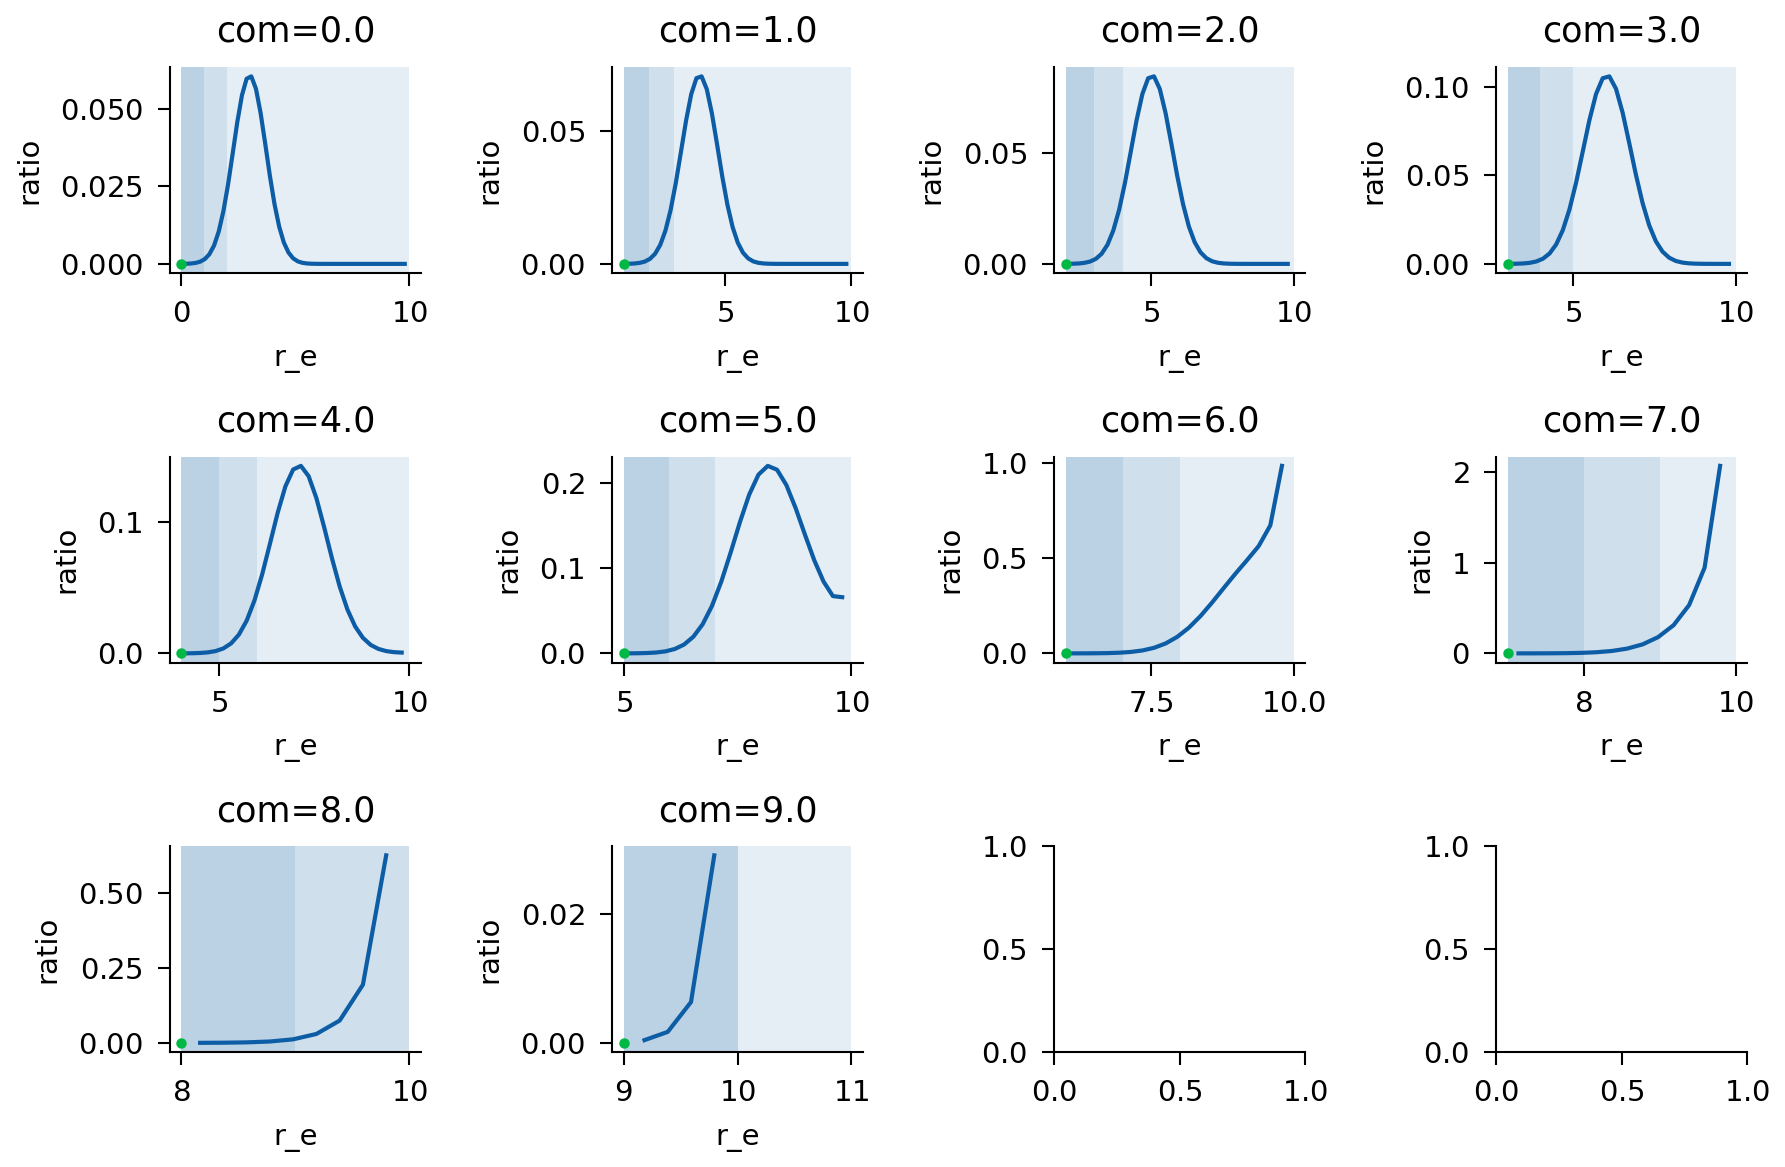

In [120]:
sigma = 1
radius = 2
r_e = np.linspace(0,10,50)
arr_r_e = np.vstack([r_e,np.zeros(len(r_e))]).T
com = np.arange(0,10,1)
arr_com = np.vstack([com,np.zeros(len(com))]).T
arr_lst = []
for com in tqdm(arr_com):
    arr = init(mesh,3,com,arr_r_e[arr_r_e[:,0]>com[0]],sigma)
    arr_lst.append(np.hstack([com[0]*np.ones(len(arr))[:,np.newaxis],arr]))
arr = init(mesh,3,np.array([0,0]),arr_r_e,sigma)
df = pd.DataFrame(np.vstack(arr_lst),columns=["com","r_e","integral","displacement"])
df["ratio"] = df["integral"]/df["displacement"]
pivot = df.pivot_table(values="ratio",index="com",columns="r_e")
fig,ax = plt.subplots(3,4)
fig.set_size_inches(6,4)
ax = np.ravel(ax)
for i, com in enumerate(df["com"].unique()):
    ax[i].set_title(f"com={com}")
    ax[i].axvspan(com,10,zorder=-10,alpha=0.1)
    ax[i].axvspan(com,com+sigma,zorder=-10,alpha=0.1)
    ax[i].axvspan(com,com+radius,zorder=-10,alpha=0.1)
    g = sns.lineplot(df[(df["com"]==com)],x="r_e",y="ratio",ax=ax[i])
    ax[i].plot(com,0,marker=".")
fig.tight_layout()

100%|██████████| 10/10 [00:37<00:00,  3.73s/it]


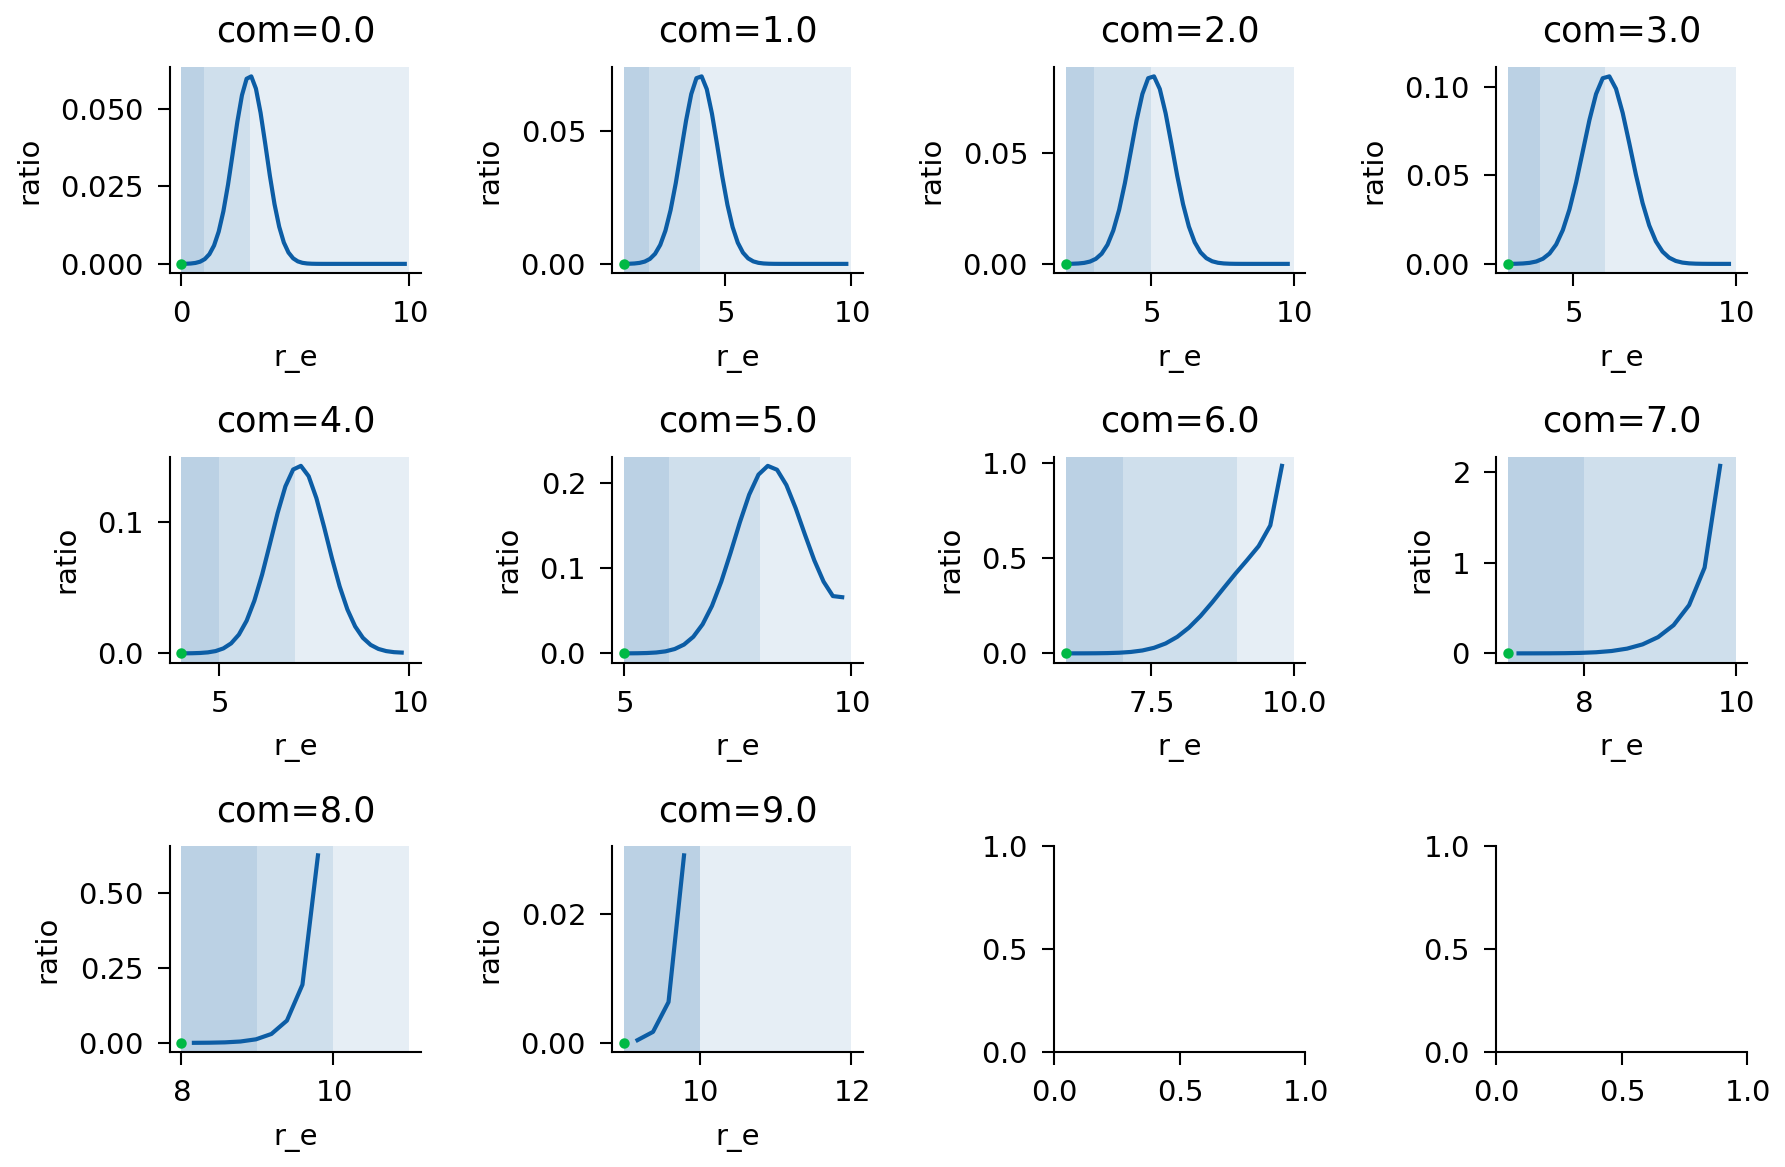

In [121]:
sigma = 1
radius = 3
r_e = np.linspace(0,10,50)
arr_r_e = np.vstack([r_e,np.zeros(len(r_e))]).T
com = np.arange(0,10,1)
arr_com = np.vstack([com,np.zeros(len(com))]).T
arr_lst = []
for com in tqdm(arr_com):
    arr = init(mesh,3,com,arr_r_e[arr_r_e[:,0]>com[0]],sigma)
    arr_lst.append(np.hstack([com[0]*np.ones(len(arr))[:,np.newaxis],arr]))
arr = init(mesh,3,np.array([0,0]),arr_r_e,sigma)
df = pd.DataFrame(np.vstack(arr_lst),columns=["com","r_e","integral","displacement"])
df["ratio"] = df["integral"]/df["displacement"]
pivot = df.pivot_table(values="ratio",index="com",columns="r_e")
fig,ax = plt.subplots(3,4)
fig.set_size_inches(6,4)
ax = np.ravel(ax)
for i, com in enumerate(df["com"].unique()):
    ax[i].set_title(f"com={com}")
    ax[i].axvspan(com,10,zorder=-10,alpha=0.1)
    ax[i].axvspan(com,com+sigma,zorder=-10,alpha=0.1)
    ax[i].axvspan(com,com+radius,zorder=-10,alpha=0.1)
    g = sns.lineplot(df[(df["com"]==com)],x="r_e",y="ratio",ax=ax[i])
    ax[i].plot(com,0,marker=".")
fig.tight_layout()

100%|██████████| 10/10 [00:37<00:00,  3.71s/it]


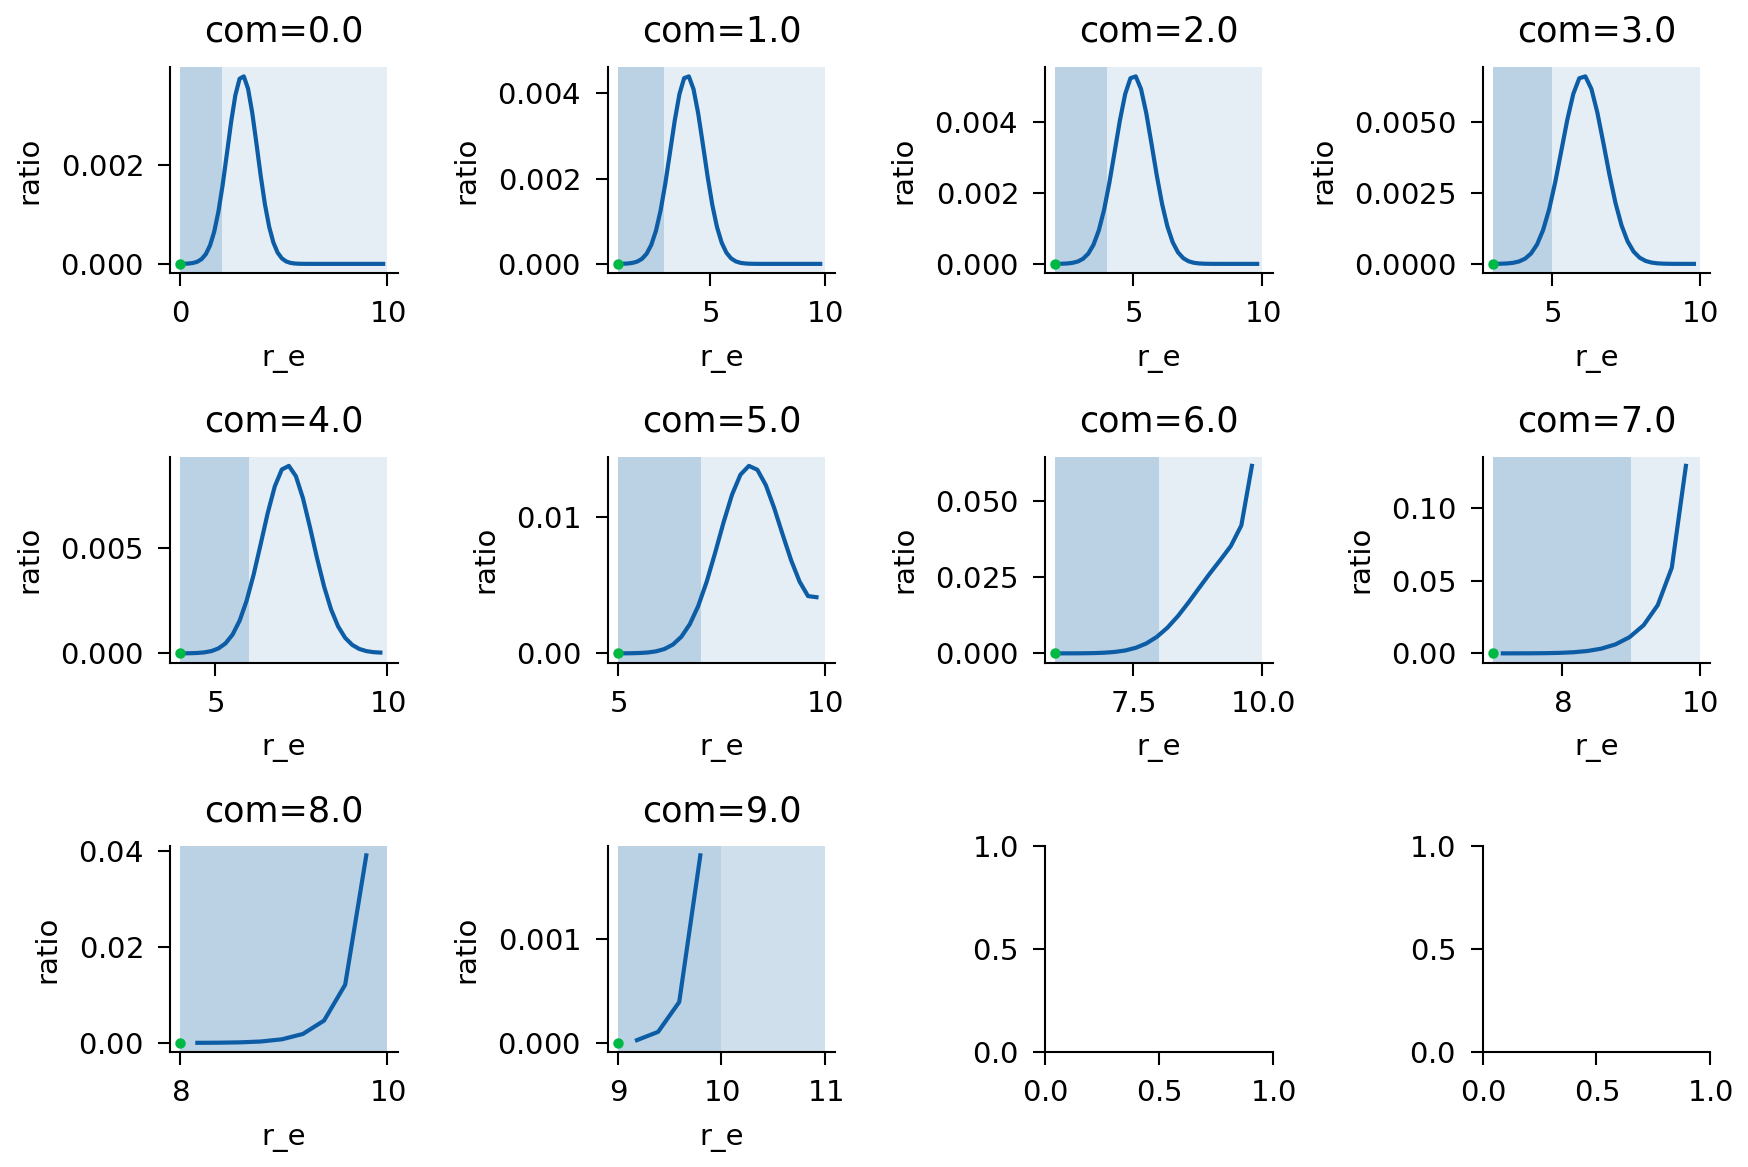

In [122]:
sigma = 2
radius = 2
r_e = np.linspace(0,10,50)
arr_r_e = np.vstack([r_e,np.zeros(len(r_e))]).T
com = np.arange(0,10,1)
arr_com = np.vstack([com,np.zeros(len(com))]).T
arr_lst = []
for com in tqdm(arr_com):
    arr = init(mesh,3,com,arr_r_e[arr_r_e[:,0]>com[0]],sigma)
    arr_lst.append(np.hstack([com[0]*np.ones(len(arr))[:,np.newaxis],arr]))
arr = init(mesh,3,np.array([0,0]),arr_r_e,sigma)
df = pd.DataFrame(np.vstack(arr_lst),columns=["com","r_e","integral","displacement"])
df["ratio"] = df["integral"]/df["displacement"]
pivot = df.pivot_table(values="ratio",index="com",columns="r_e")
fig,ax = plt.subplots(3,4)
fig.set_size_inches(6,4)
ax = np.ravel(ax)
for i, com in enumerate(df["com"].unique()):
    ax[i].set_title(f"com={com}")
    ax[i].axvspan(com,10,zorder=-10,alpha=0.1)
    ax[i].axvspan(com,com+sigma,zorder=-10,alpha=0.1)
    ax[i].axvspan(com,com+radius,zorder=-10,alpha=0.1)
    g = sns.lineplot(df[(df["com"]==com)],x="r_e",y="ratio",ax=ax[i])
    ax[i].plot(com,0,marker=".")
fig.tight_layout()

100%|██████████| 10/10 [00:37<00:00,  3.78s/it]


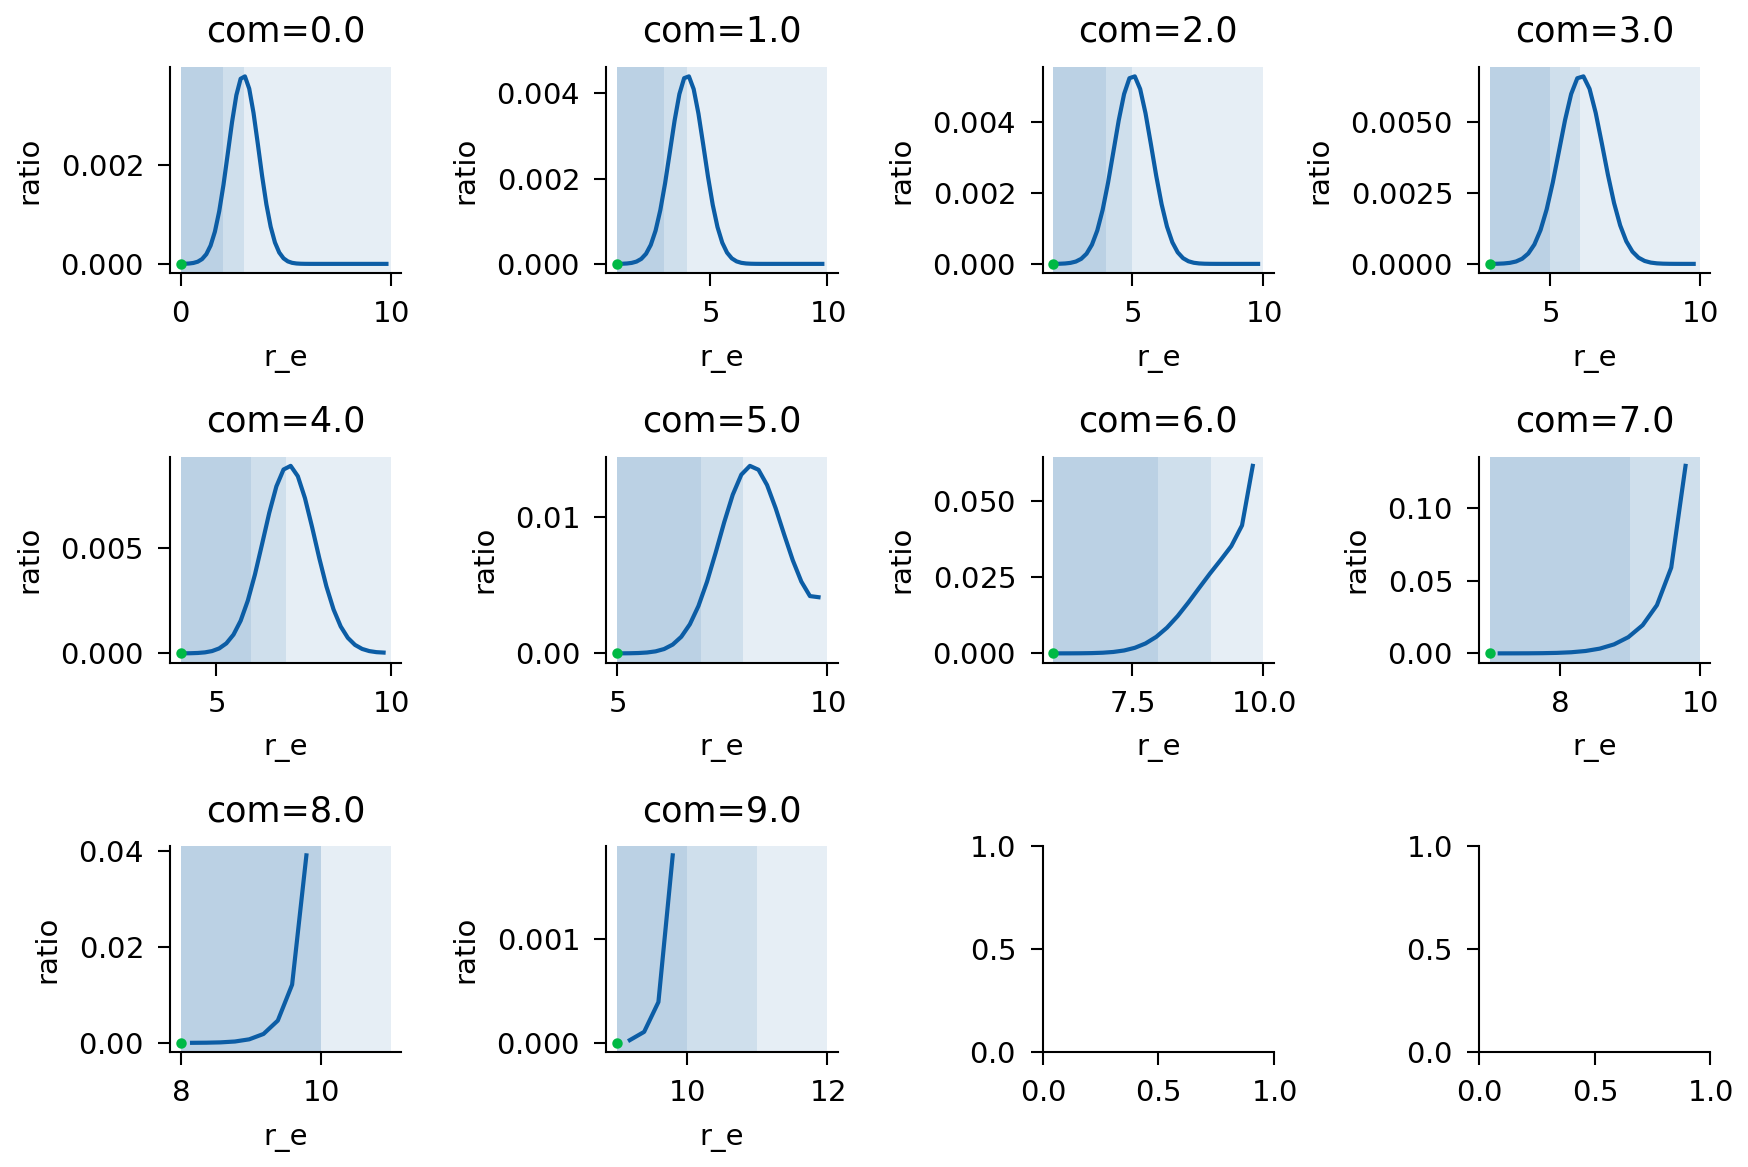

In [124]:
sigma = 2
radius = 3
r_e = np.linspace(0,10,50)
arr_r_e = np.vstack([r_e,np.zeros(len(r_e))]).T
com = np.arange(0,10,1)
arr_com = np.vstack([com,np.zeros(len(com))]).T
arr_lst = []
for com in tqdm(arr_com):
    arr = init(mesh,3,com,arr_r_e[arr_r_e[:,0]>com[0]],sigma)
    arr_lst.append(np.hstack([com[0]*np.ones(len(arr))[:,np.newaxis],arr]))
arr = init(mesh,3,np.array([0,0]),arr_r_e,sigma)
df = pd.DataFrame(np.vstack(arr_lst),columns=["com","r_e","integral","displacement"])
df["ratio"] = df["integral"]/df["displacement"]
pivot = df.pivot_table(values="ratio",index="com",columns="r_e")
fig,ax = plt.subplots(3,4)
fig.set_size_inches(6,4)
ax = np.ravel(ax)
for i, com in enumerate(df["com"].unique()):
    ax[i].set_title(f"com={com}")
    ax[i].axvspan(com,10,zorder=-10,alpha=0.1)
    ax[i].axvspan(com,com+sigma,zorder=-10,alpha=0.1)
    ax[i].axvspan(com,com+radius,zorder=-10,alpha=0.1)
    g = sns.lineplot(df[(df["com"]==com)],x="r_e",y="ratio",ax=ax[i])
    ax[i].plot(com,0,marker=".")
fig.tight_layout()

100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


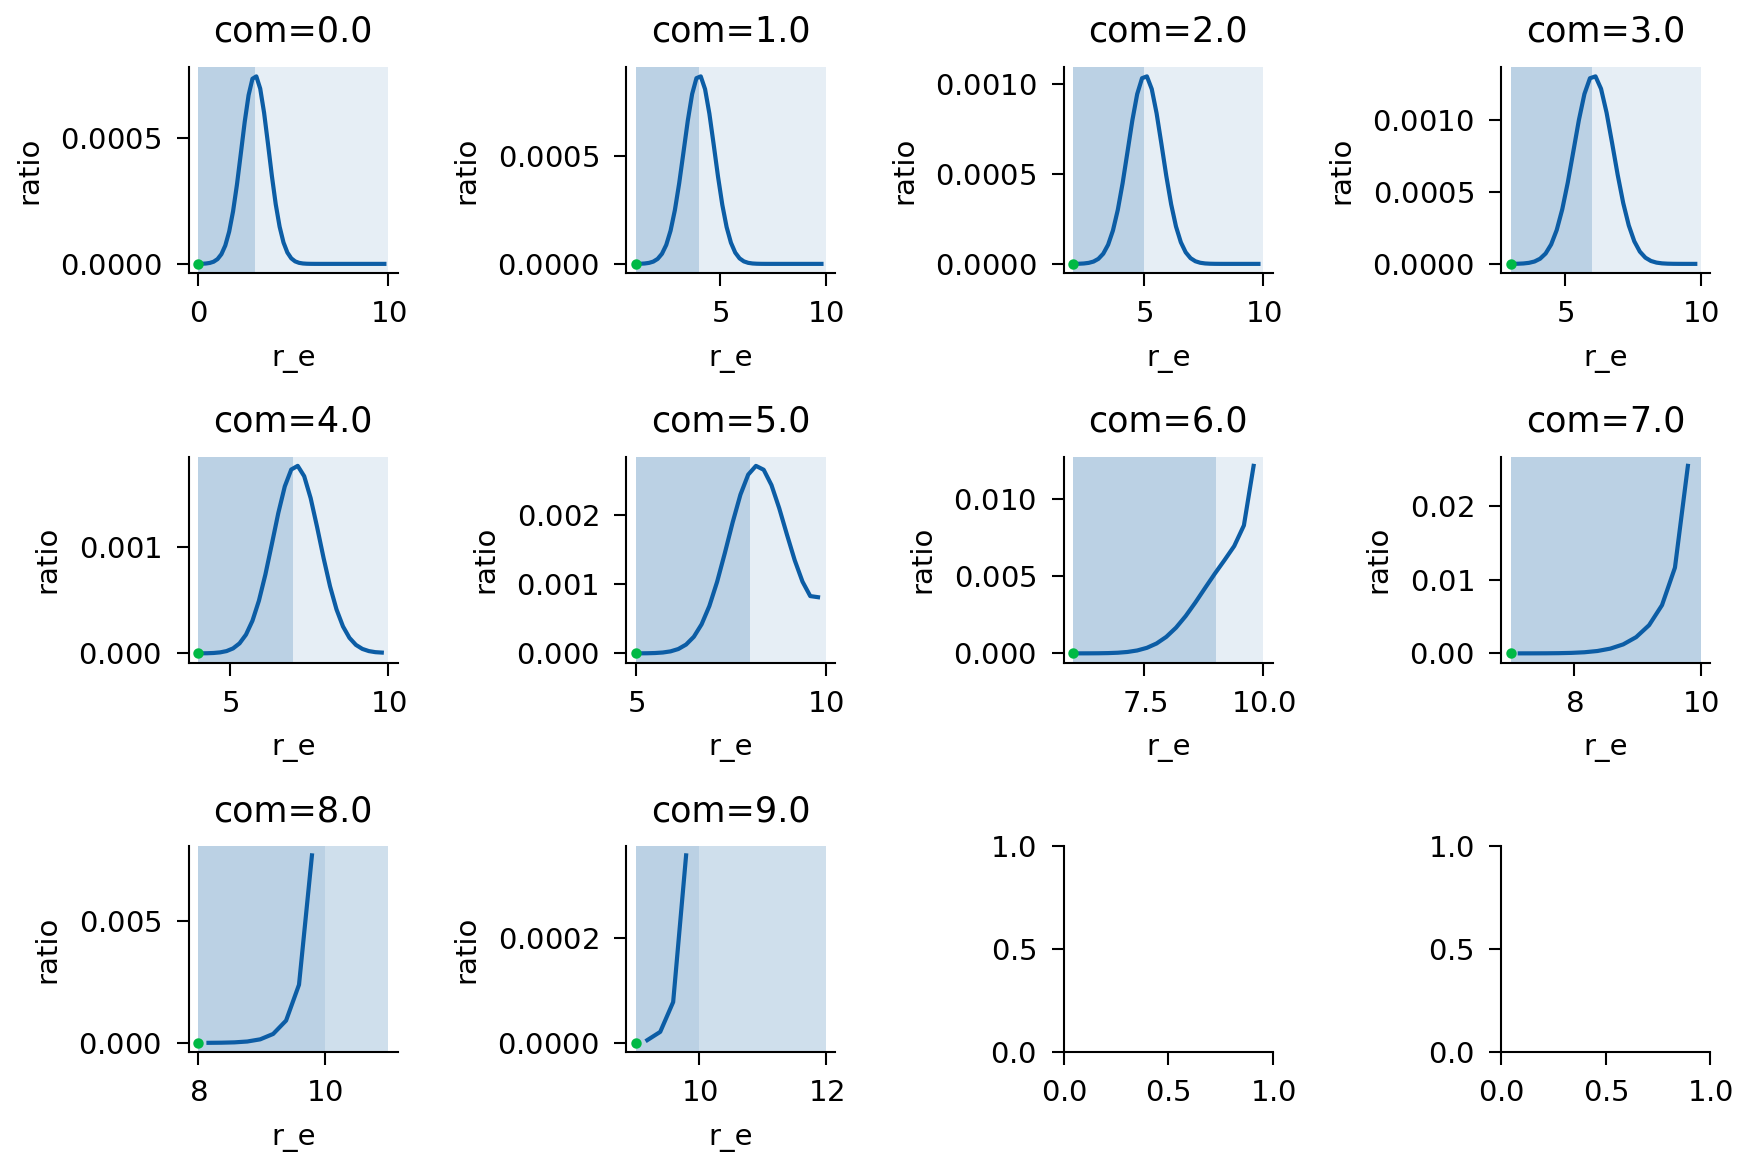

In [123]:
sigma = 3
radius = 3
r_e = np.linspace(0,10,50)
arr_r_e = np.vstack([r_e,np.zeros(len(r_e))]).T
com = np.arange(0,10,1)
arr_com = np.vstack([com,np.zeros(len(com))]).T
arr_lst = []
for com in tqdm(arr_com):
    arr = init(mesh,3,com,arr_r_e[arr_r_e[:,0]>com[0]],sigma)
    arr_lst.append(np.hstack([com[0]*np.ones(len(arr))[:,np.newaxis],arr]))
arr = init(mesh,3,np.array([0,0]),arr_r_e,sigma)
df = pd.DataFrame(np.vstack(arr_lst),columns=["com","r_e","integral","displacement"])
df["ratio"] = df["integral"]/df["displacement"]
pivot = df.pivot_table(values="ratio",index="com",columns="r_e")
fig,ax = plt.subplots(3,4)
fig.set_size_inches(6,4)
ax = np.ravel(ax)
for i, com in enumerate(df["com"].unique()):
    ax[i].set_title(f"com={com}")
    ax[i].axvspan(com,10,zorder=-10,alpha=0.1)
    ax[i].axvspan(com,com+sigma,zorder=-10,alpha=0.1)
    ax[i].axvspan(com,com+radius,zorder=-10,alpha=0.1)
    g = sns.lineplot(df[(df["com"]==com)],x="r_e",y="ratio",ax=ax[i])
    ax[i].plot(com,0,marker=".")
fig.tight_layout()

100%|██████████| 5/5 [03:36<00:00, 43.28s/it]


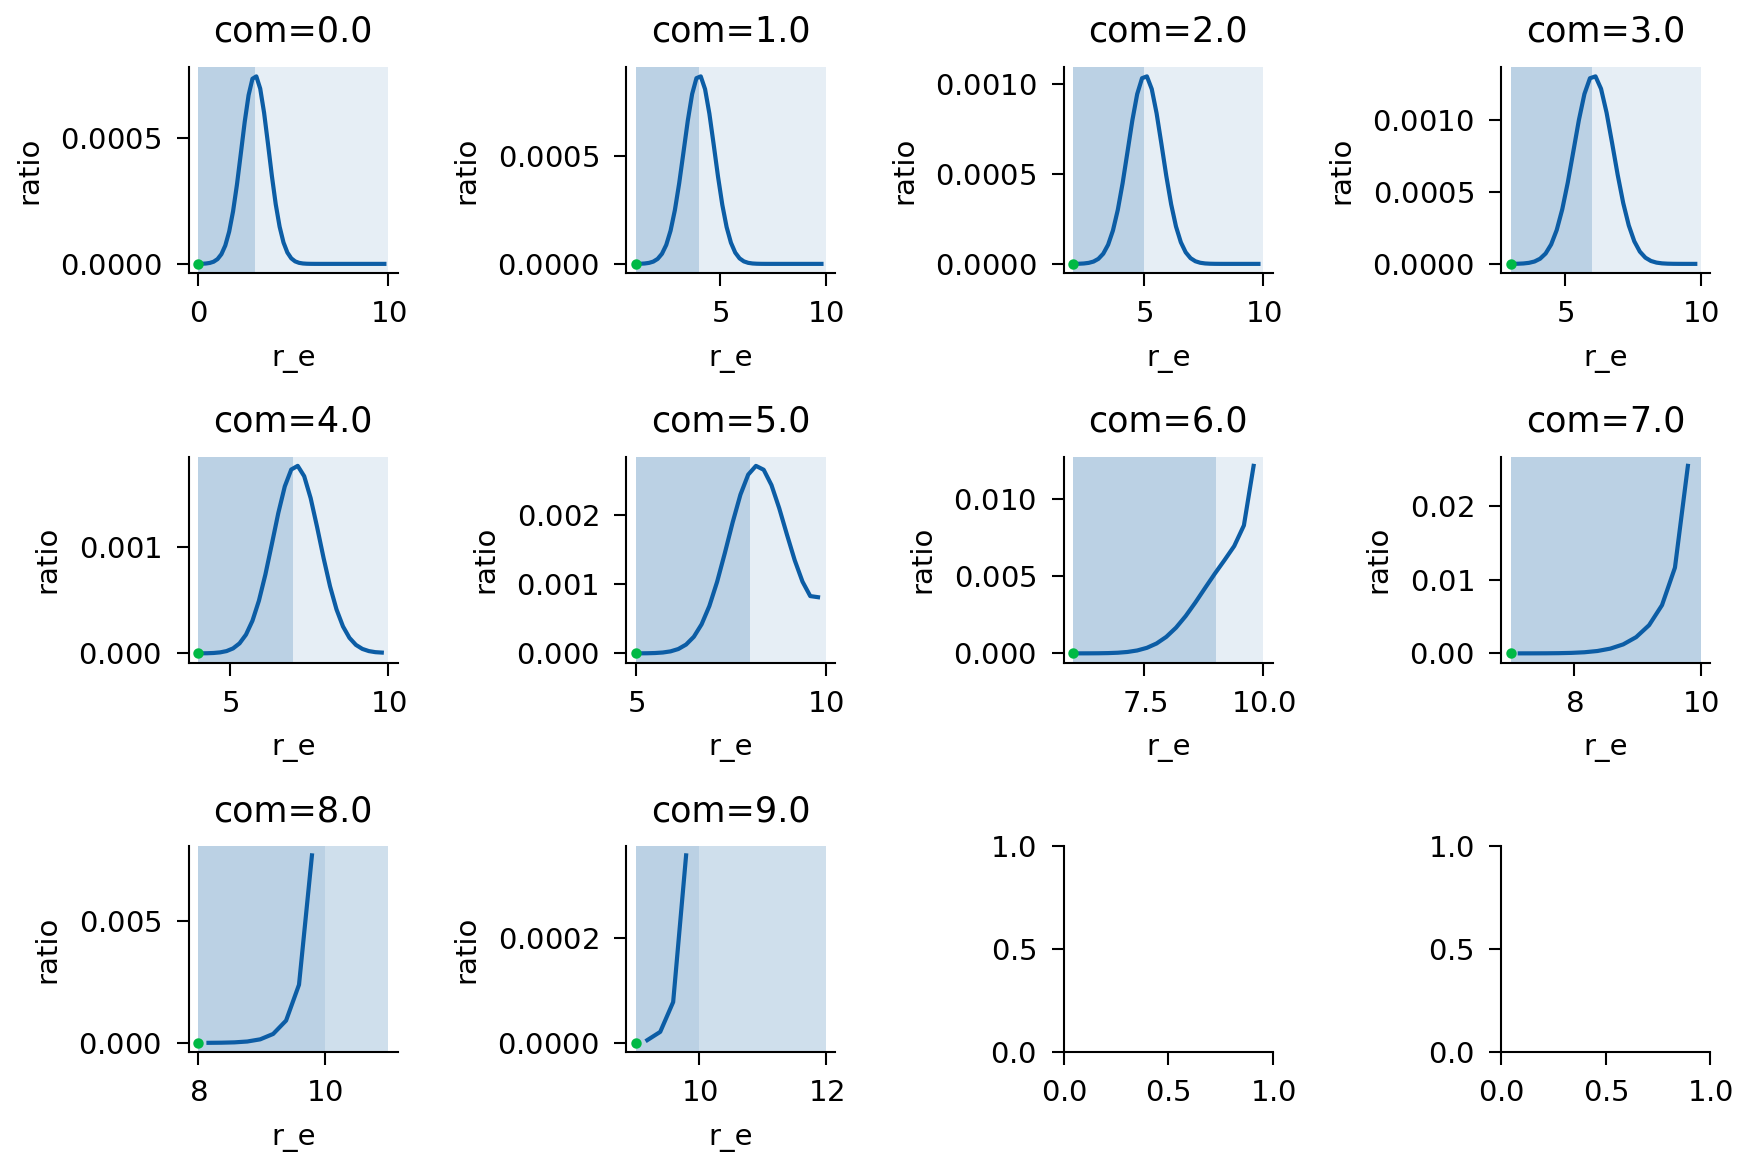

In [129]:
sig_eps_lst = [[1,2],[1,3],[2,2],[2,3],[3,3]]
df_lst = []
for sigma, epsilon in tqdm(sig_eps_lst):
    r_e = np.linspace(0,10,50)
    arr_r_e = np.vstack([r_e,np.zeros(len(r_e))]).T
    com = np.arange(0,10,1)
    arr_com = np.vstack([com,np.zeros(len(com))]).T
    arr_lst = []
    for com in tqdm(arr_com):
        arr = init(mesh,3,com,arr_r_e[arr_r_e[:,0]>com[0]],sigma)
        arr_lst.append(np.hstack([com[0]*np.ones(len(arr))[:,np.newaxis],arr]))
    arr = init(mesh,3,np.array([0,0]),arr_r_e,sigma)
    df = pd.DataFrame(np.vstack(arr_lst),columns=["com","r_e","integral","displacement"])
    df["ratio"] = df["integral"]/df["displacement"]
    df_lst.append(df)

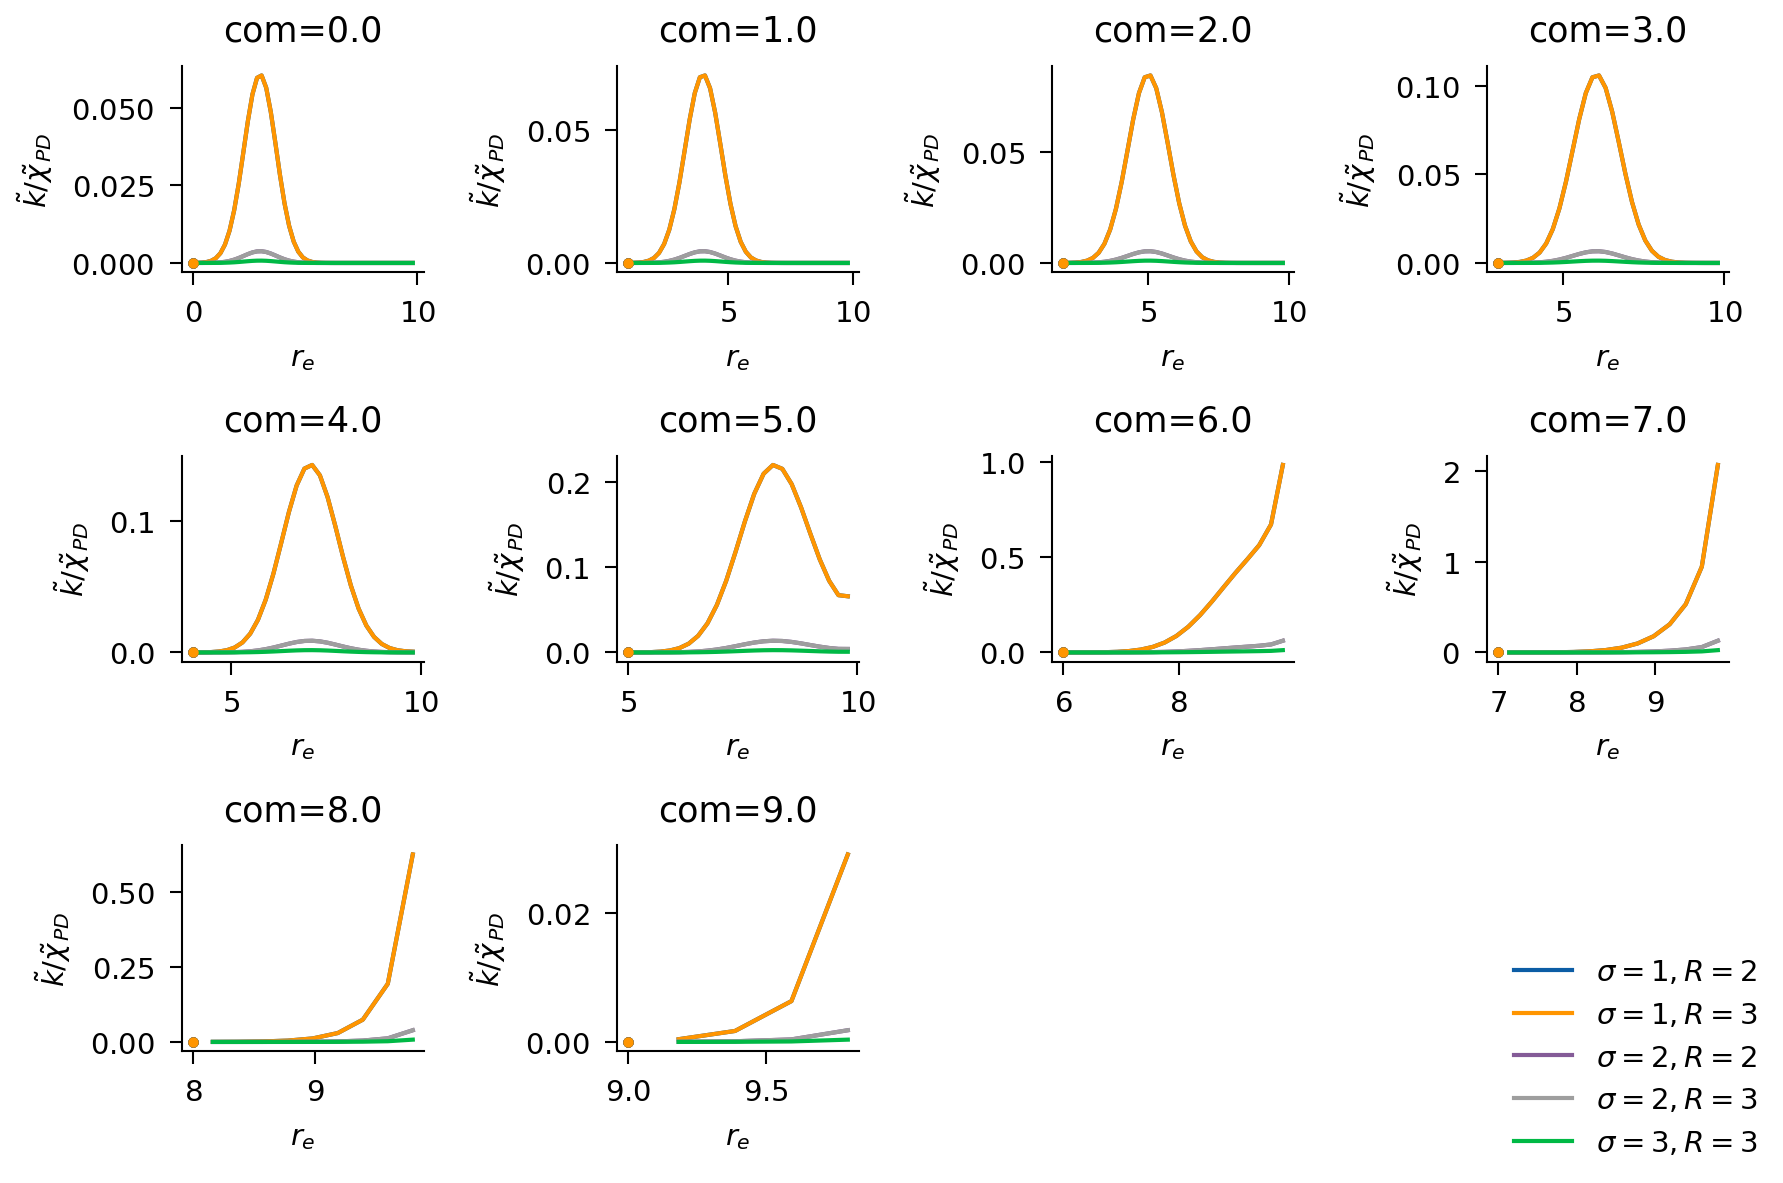

In [155]:
fig,ax = plt.subplots(3,4)
fig.set_size_inches(6,4)
ax = np.ravel(ax)

for num, (sigma, epsilon) in enumerate(sig_eps_lst):
    df = df_lst[num]
    for i, com in enumerate(df["com"].unique()):
        ax[i].set_title(f"com={com}")
        # ax[i].axvspan(com,10,zorder=-10,alpha=0.1)
        # ax[i].axvspan(com,com+sigma,zorder=-10,alpha=0.1)
        # ax[i].axvspan(com,com+radius,zorder=-10,alpha=0.1)
        subdf = df[(df["com"]==com)]
        x = subdf["r_e"]
        y = subdf["ratio"]
        ax[i].plot(x,y,label=f"$\sigma={sigma},R={epsilon}$")
        ax[i].plot(com,0,marker=".")
        ax[i].set_xlabel("$r_e$")
        ax[i].set_ylabel(r"$\tilde k/\tilde \chi_{PD}$")
    fig.tight_layout()
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])


In [78]:
for i, com in enumerate(df["com"].unique()):
    ax[i].set_title(f"com={com}")
    ax[i].axvspan(com,10,zorder=-10,alpha=0.1)
    g = sns.lineplot(df[(df["com"]==com)],x="r_e",y="ratio",ax=ax[i])
    ax[i].plot(com,0,marker=".")
fig.tight_layout()

In [ ]:
radius = 3
r_e = np.linspace(0,10,50)
arr_r_e = np.vstack([r_e,np.zeros(len(r_e))]).T
com = np.arange(0,10+1,1)
arr_com = np.vstack([com,np.zeros(len(com))]).T
lst = []
for com in tqdm(arr_com):
    lst.append(init(mesh, radius, com, np.array([[3,0]])))
arr_lst = []
for com in tqdm(arr_com):
    arr = init(mesh,3,com,arr_r_e)
    arr_lst.append(np.hstack([com[0]*np.ones(len(arr))[:,np.newaxis],arr]))
arr = init(mesh,3,np.array([0,0]),arr_r_e)
df = pd.DataFrame(np.vstack(arr_lst),columns=["com","r_e","integral","displacement"])
df["ratio"] = df["integral"]/df["displacement"]
pivot = df.pivot_table(values="ratio",index="com",columns="r_e")
fig,ax = plt.subplots(3,4)
fig.set_size_inches(5,4)
ax = np.ravel(ax)
for i, com in enumerate(df["com"].unique()):
    ax[i].set_title(f"com={com}")
    ax[i].axvspan(com,10,zorder=-10,alpha=0.1)
    g = sns.lineplot(df[(df["com"]==com)],x="r_e",y="ratio",ax=ax[i])
    ax[i].plot(com,0,marker=".")
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots()
cs = ax.tricontourf(mesh.x,
                    mesh.y,
                    c_vector,
                    levels=np.linspace(c_light,
                                       c_dense+0.1,
                                       256),
                    cmap="Blues")
border = plt.Circle((0,0), 15, color='tab:gray', fill=False, linewidth=2)
ax.add_patch(border)
ax.autoscale_view()
ax.xaxis.set_tick_params(labelbottom=False, bottom=False)
ax.yaxis.set_tick_params(labelleft=False, left=False)
ax.set_aspect('equal', 'box')
ax.plot(r_e_0[0],r_e_0[1],marker=".",markersize=12,color="k")
ax.annotate('$r_{e,0}$',xy=r_e_0,fontsize=12,textcoords="offset points",xytext=(5,5))
ax.plot(r_p[0],r_p[1],marker=".",markersize=12,color="k")
ax.annotate('$r_{p}$',xy=r_p,fontsize=12,textcoords="offset points",xytext=(5,5))
ax.plot(r_e[0],r_e[1],marker=".",markersize=12,color="k")
ax.annotate('$r_{e}$',xy=r_e,fontsize=12,textcoords="offset points",xytext=(5,5))
plt.setp(ax.spines.values(), visible=False)

In [172]:
def hill(x,shift,coefficient,prefactor,basal):
    return prefactor*((x-shift)**coefficient)/((x-shift)**coefficient+1)+basal

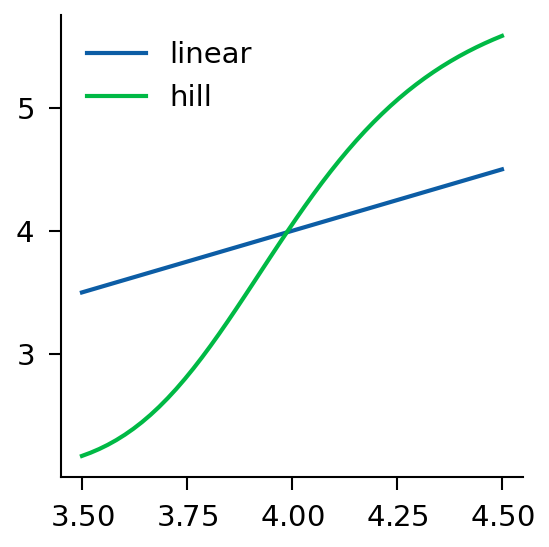

In [195]:
x = np.linspace(3.5,4.5)
fig, ax = plt.subplots()
ax.plot(x,x,label="linear")
ax.plot(x,hill(x,shift=3,coefficient=5,prefactor=4,basal=2.05),label="hill")
ax.set_box_aspect(1)
ax.legend()